In [1]:
using DrWatson
quickactivate(@__DIR__)
Base.LOAD_PATH .= findproject(@__DIR__);

import Baysor as B
import BaysorAnalysis as BA

import CairoMakie as MK
import Colors
import CSV
import Clustering
import Images
import MAT
import MultivariateStats
import Plots
import PlotThemes
import PyPlot as Plt
import Seaborn as Sns

using DataFrames
using DataFramesMeta
using NearestNeighbors
using ProgressMeter
using RCall
using SparseArrays
using Statistics
using StatsBase
using StatsPlots

ProgressMeter.ijulia_behavior(:clear);
MK.activate!(type = "png");
BA.set_pyplot_defaults!()
cplotsdir(args...) = plotsdir("benchmarking", args...);

In [2]:
R"""
library(ggplot2)
#library(ggrastr)
#library(ggforce)
theme_set(theme_bw())
""";

plotCorrelationEffect = R"""
function(df, frac_col, ymax=1.0, ylabel=ifelse(frac_col == "MolFrac", "Fraction of mismatching molecules", "Fraction of mismatching cells"), legend_pos=c(0,1), 
         color_pal=scales::hue_pal()(4)) {
    low.max <- max(df[[frac_col]][df$Correlation < 0.5])
    ggplot() + 
        geom_rect(aes(xmin=0.01, xmax=0.5, ymin=0.001, ymax=ym), data.frame(ym=low.max), alpha=0.5, fill=alpha("white", 0.0), color="black") +
        geom_line(aes(x=Correlation, y=.data[[frac_col]], color=Dataset, linetype=Segmentation), df) +
        theme(legend.position=legend_pos, legend.justification=legend_pos, legend.background=element_rect(fill=alpha('white', 0.2)), legend.box='horizontal') +
        guides(color=guide_legend(order=1), title="Source segmentation") +
        labs(x="Maximal correlation", y=ylabel) +
        scale_color_manual(values=color_pal) +
        scale_x_continuous(limits=c(0, 1.01), expand=c(0, 0)) +
        scale_y_continuous(limits=c(0, ymax), expand=c(0, 0))
}
""";

## Load data

In [3]:
@time merfish = BA.load_merfish(paper_polygons=true, dapi=true, watershed=true);

224.870701 seconds (195.59 M allocations: 21.269 GiB, 3.07% gc time, 7.60% compilation time)


In [ ]:
# import HDF5
# @time dapi = HDF5.h5read("/home/vpetukhov/data/spatal/linnarsson/Nuclei_polyT.int16.sf.hdf5", "/nuclei");
# t_quant = UInt(quantile(vec(dapi), 0.995));
# dapi[dapi .> t_quant] .= t_quant;

# @time Images.save("/home/vpetukhov/data/spatal/linnarsson/nuclei.tif", dapi);

In [4]:
@time osmfish = BA.load_osmfish(paper_polygons=true, dapi=true, watershed=true);

898.607586 seconds (133.99 M allocations: 53.491 GiB, 2.42% gc time, 51.02% compilation time)


In [5]:
@time starmap1020 = BA.load_starmap1020(paper_polygons=true);
starmap1020[:name] = "STARmap";

 10.302879 seconds (24.37 M allocations: 2.677 GiB, 11.01% gc time, 1.91% compilation time)


In [6]:
@time allen_smfish = BA.load_allen_smfish(paper_polygons=true, dapi=true, watershed=true);

┌ Warning: Minimum transcript coordinates are < 1: (0, 0). Filling it with 0.
└ @ Baysor /home/vpetukhov/.julia/dev/Baysor/src/data_processing/initialization.jl:279
┌ Warning: Maximum transcript coordinates are (21604, 23512), which is larger than the DAPI size: (21590, 23450). Filling it with 0.
└ @ Baysor /home/vpetukhov/.julia/dev/Baysor/src/data_processing/initialization.jl:275
┌ Warning: Minimum transcript coordinates are < 1: (0, 0). Filling it with 0.
└ @ Baysor /home/vpetukhov/.julia/dev/Baysor/src/data_processing/initialization.jl:279


 87.863206 seconds (38.12 M allocations: 16.996 GiB, 10.80% gc time, 0.37% compilation time)


In [7]:
@time iss = BA.load_iss(paper_polygons=true, dapi=true, watershed=true);

 27.796140 seconds (18.61 M allocations: 3.957 GiB, 18.30% gc time, 2.48% compilation time)


In [205]:
datasets = deepcopy((allen_smfish=allen_smfish, iss=iss, merfish=merfish, osmfish=osmfish, starmap1020=starmap1020));

## Compare

### Pre-process and detailed plots

In [206]:
cell_col_names = [:cell, :cell_paper, :cell_watershed, :cell_pciseq, :cell_prior];
cell_col_labels = ["Baysor", "Paper", "Watershed", "pciSeq", "Baysor with prior"];
alias_per_col = Dict(Pair.(cell_col_names, cell_col_labels)...);

color_per_label = BA.method_palette();
color_per_label["Paper"] = color_per_label["IF"];
color_per_label["Baysor with prior"] = color_per_label["Baysor, IF prior"];
delete!(color_per_label, "IF");
delete!(color_per_label, "Baysor, IF prior");

for k in keys(datasets)
    BA.append_matching_statistics!(datasets[k], cell_col_names)
    println(k)
end

delete!(datasets[:iss], :part_cors_cell_paper);
delete!(datasets[:iss], :part_cors_paper_watershed);
delete!(datasets[:iss], :part_cors_cell_watershed);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


allen_smfish


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


iss


Progress: 100%|█████████████████████████████████████████| Time: 0:04:06


merfish


Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


osmfish


┌ Warning: The following col names weren't found in the data: [:cell_watershed, :cell_pciseq]
└ @ BaysorAnalysis /home/vpetukhov/spatial/BaysorAnalysis/src/validation.jl:400
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


starmap1020


In [ ]:
# for k in keys(datasets)
#     println(k)
#     display(B.plot_qc_comparison(datasets[k][:qc_per_cell_dfs], max_quants=[0.995, 0.99, 0.99, 0.999, 0.999], labels=cell_col_labels))
# end

In [38]:
# for k in keys(datasets)
#     println(k)
#     display(BA.plot_matching_comparison(datasets[k][:match_res]))
# end

In [41]:
# for k in keys(datasets)
#     display(datasets[k][:stat_df])
# end

In [40]:
# @time for k in keys(datasets)
#     if k == :iss
#         continue
#     end
#     d = datasets[k]
#     t_bins = -0.05:0.02:1.0
#     plt = Plots.histogram(d[:part_cors][1][1], bins=t_bins, widen=false, label="Baysor", legend=:topleft, 
#         xlabel="Correlation", ylabel="Num. of cells", title=k, size=(400, 300));
#     Plots.histogram!(d[:part_cors][2][1], bins=t_bins, label="Paper", alpha=0.6)
#     display(plt)
# end

### Assignment stats

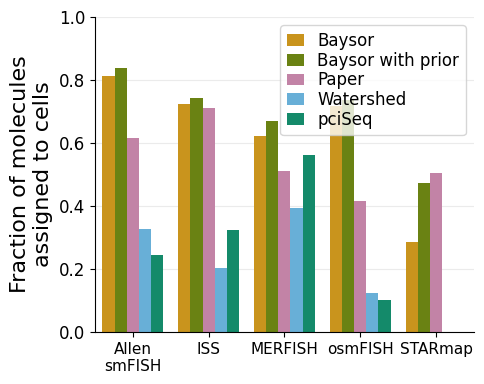

In [263]:
p_df = vcat([vcat([DataFrame(:Protocol => d[:name], :Frac => mean(d[:df][!, s] .!= 0), :Type => n) for d in datasets if s in propertynames(d[:df])]...) 
        for (s,n) in zip(cell_col_names, cell_col_labels)]...);
p_df.Protocol[p_df.Protocol .== "Allen smFISH"] .= "Allen\nsmFISH";

fig = Plt.figure(figsize=(5,4), frameon=false)
ax = Sns.barplot(x=p_df.Protocol, y=p_df.Frac, hue=p_df.Type, palette=color_per_label, hue_order=sort(unique(p_df.Type)))
Plt.ylim(0, 1)
Plt.legend(loc="upper right", frameon=true, labelspacing=0.1, handlelength=1, borderpad=0.4)
Plt.ylabel("Fraction of molecules\nassigned to cells");
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11);
Plt.tight_layout();
Plt.savefig(cplotsdir("assignment_frac.pdf"));

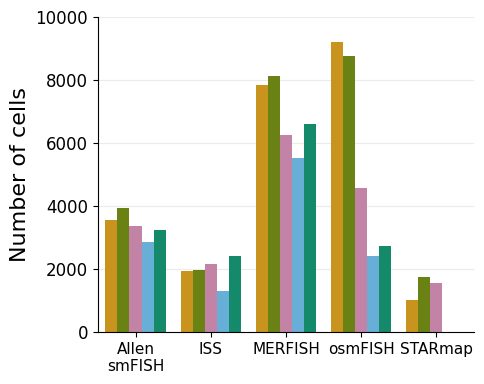

In [252]:
p_df = vcat([vcat([DataFrame(:Protocol => d[:name], :Frac => size(df,1), :Type => alias_per_col[c]) 
                for (c,df) in d[:qc_per_cell_dfs]]...) for d in datasets]...);
p_df.Protocol[p_df.Protocol .== "Allen smFISH"] .= "Allen\nsmFISH";

fig = Plt.figure(figsize=(5, 4), frameon=false)
ax = Sns.barplot(x=p_df.Protocol, y=p_df.Frac, hue=p_df.Type, palette=color_per_label, hue_order=sort(unique(p_df.Type)))
Plt.ylim(0, 10000)
# Plt.legend(loc="upper right", frameon=true, labelspacing=0, handlelength=1)
Plt.legend([], [])
Plt.ylabel("Number of cells");
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11);
Plt.tight_layout();
Plt.savefig(cplotsdir("num_cells.pdf"));

In [210]:
import Clustering: mutualinfo

col_combinations = vcat([[(cell_col_names[i], cell_col_names[j]) for j in 1:(i-1)] for i in 1:length(cell_col_names)]...);
p_df = [[Dict(:mi => mutualinfo(d[:df][!,c1], d[:df][!,c2]), :protocol => d[:name], :pair => alias_per_col[c1] * " vs " * alias_per_col[c2])
    for (c1,c2) in col_combinations if (c1 in propertynames(d[:df])) && (c2 in propertynames(d[:df]))] for d in datasets];
p_df = DataFrame(vcat(p_df...));

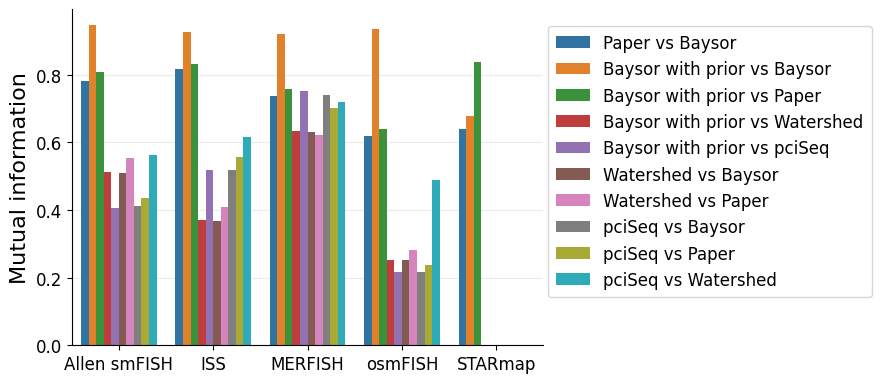

In [211]:
hue_order = vcat(["Paper vs Baysor"], setdiff(sort(unique(p_df.pair)), ["Paper vs Baysor"]))
Plt.figure(figsize=(9,4))
ax = Sns.barplot(x=p_df.protocol, y=p_df.mi, hue=p_df.pair, hue_order=hue_order)
Plt.legend(bbox_to_anchor=(1.01, 0.95), borderaxespad=0, frameon=true, borderpad=0.5)
Plt.ylabel("Mutual information")
ax.set_xticklabels(ax.get_xticklabels());
Plt.tight_layout();
Plt.savefig(cplotsdir("pairwise_mutual_info.pdf"));

### Correlation plots

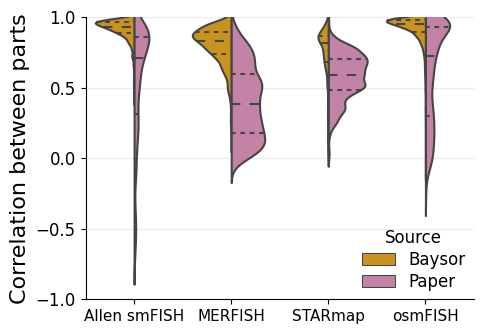

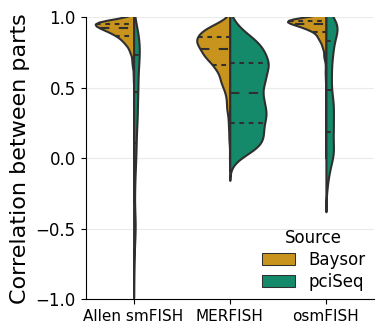

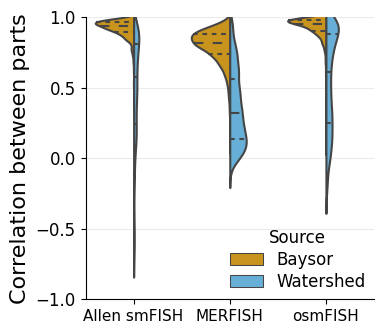

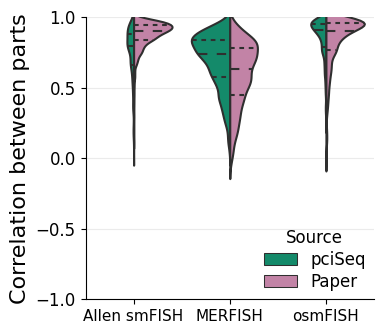

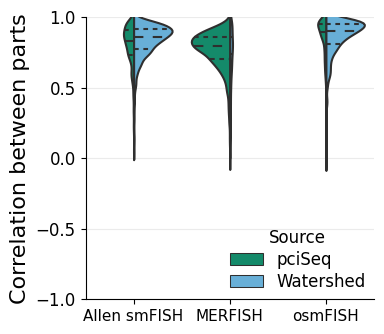

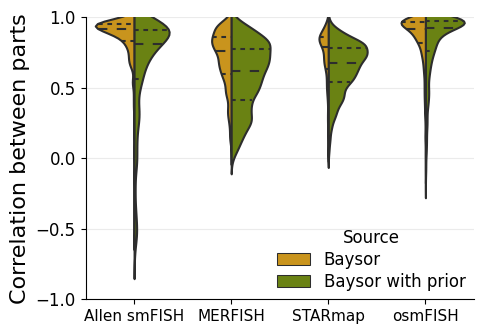

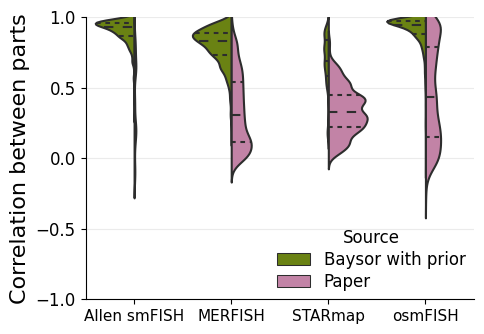

In [303]:
cor_combs = [(:part_cors_cell_paper, "Baysor", "Paper"), (:part_cors_cell_pciseq, "Baysor", "pciSeq"), (:part_cors_cell_watershed, "Baysor", "Watershed"), 
    (:part_cors_pciseq_paper, "pciSeq", "Paper"), (:part_cors_pciseq_watershed, "pciSeq", "Watershed"),
    (:part_cors_cell_prior, "Baysor", "Baysor with prior"), (:part_cors_prior_paper, "Baysor with prior", "Paper")]
for (pcr, l1, l2) in cor_combs
    p_df = vcat([vcat([DataFrame(:Correlation => d[pcr][i][1], :Type => d[:name], :Source => t) for d in datasets if (pcr in keys(d)) && (d[:name] != "ISS")]...) 
        for (i,t) in enumerate([l1, l2])]...);
    p_df = @orderby(p_df, :Type)

    fw = (length(unique(p_df.Type)) == 4) ? 5 : 4
    Plt.figure(figsize=(fw, 3.5))
    ax = Sns.violinplot(x=p_df.Type, y=p_df.Correlation, hue=p_df.Source, split=true, inner="quart", palette=color_per_label, bw=0.2, scale="count")
    ax.legend(title="Source", loc="lower right", frameon=false, labelspacing=0.25)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=11)
    Plt.ylim(-1.0, 1);
    Plt.yticks(-1.0:0.5:1.0)
    Plt.ylabel("Correlation between parts");
    Plt.tight_layout()
    Plt.savefig(cplotsdir("expression_correlation/$(lowercase(l1))_$(lowercase(l2)).pdf"), transparent=true);
end

In [302]:
d_subs = NamedTuple([k => datasets[k] for k in keys(datasets) if k != :iss]);
p_dfs = [BA.correlation_effect_size_df(d_subs, pcr, [alias_per_col[cn1], alias_per_col[cn2]], [cn1, cn2])
    for (pcr,cn1,cn2) in [(:part_cors_cell_paper, :cell, :cell_paper), (:part_cors_cell_watershed, :cell, :cell_watershed), 
            (:part_cors_cell_pciseq, :cell, :cell_pciseq), (:part_cors_pciseq_paper, :cell_pciseq, :cell_paper)]];

plts = [plotCorrelationEffect.(Ref(p_df), ["CellFrac", "MolFrac"], [0.65, 0.32]) for p_df in p_dfs];
plt = R"cowplot::plot_grid"(vcat(plts...)..., ncol=2);
R"ggsave"(cplotsdir("expression_correlation/effect_size.pdf"), plt, width=8, height=10);
RCall.ijulia_setdevice(MIME("image/svg+xml"), width=8, height=10)
plt

┌ Warning: RCall.jl: Warning: Removed 186 row(s) containing missing values (geom_path).
│ Warning: Removed 186 row(s) containing missing values (geom_path).
│ Warning: Removed 135 row(s) containing missing values (geom_path).
│ Warning: Removed 157 row(s) containing missing values (geom_path).
│ Warning: Removed 125 row(s) containing missing values (geom_path).
│ Warning: Removed 125 row(s) containing missing values (geom_path).
│ Warning: Removed 11 row(s) containing missing values (geom_path).
│ Warning: Removed 11 row(s) containing missing values (geom_path).
└ @ RCall /home/vpetukhov/.julia/packages/RCall/eRsxl/src/io.jl:160


RObject{VecSxp}


### Correlation examples

In [104]:
# for d in datasets
for n in [:osmfish, :allen_smfish, :merfish]
    d = datasets[n]
    @time neighb_cm = B.neighborhood_count_matrix(d[:df], 50);
    @time color_transformation = B.gene_composition_transformation(neighb_cm, d[:df].confidence);
    @time gene_colors = B.gene_composition_colors(neighb_cm, color_transformation);

    d[:df][!, :gene_color] = gene_colors;
    d[:df][!, :color] = deepcopy(gene_colors);
end

 20.823487 seconds (21.74 M allocations: 5.810 GiB, 23.33% gc time)
 28.623236 seconds (1.29 M allocations: 1.509 GiB, 4.07% gc time)
 84.825744 seconds (175.92 M allocations: 9.705 GiB, 11.69% gc time)
 10.253518 seconds (11.82 M allocations: 2.959 GiB, 27.67% gc time)
 36.276228 seconds (1.29 M allocations: 953.168 MiB, 2.38% gc time)
 47.701370 seconds (95.65 M allocations: 5.173 GiB, 13.26% gc time)
 32.567427 seconds (41.13 M allocations: 16.814 GiB, 23.72% gc time)
 37.994930 seconds (1.31 M allocations: 8.488 GiB, 7.37% gc time)
225.701349 seconds (332.80 M allocations: 21.285 GiB, 9.53% gc time)


In [ ]:
# t_df = @where(datasets.osmfish[:df], :x .< 19070, :x .> 19045, :y .< 19585, :y .> 19550);
# B.plot_cell_borders_polygons(t_df, annotation=datasets.osmfish[:gene_names][t_df.gene], ms=8, legend=true)

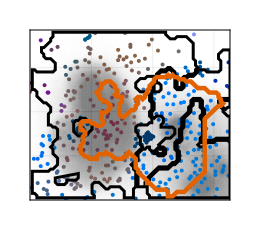

In [151]:
t_d = datasets.osmfish
xls, yls = (18900, 19160), (19480, 19710)
# xls, yls = (18900, 19160), (19480, 19790)

c_polys = t_d[:paper_polys][[all((p[:,2] .< yls[2]) .& (p[:,2] .> yls[1]) .& (p[:,1] .< xls[2]) .& (p[:,1] .> xls[1])) for p in t_d[:paper_polys]]];
plt = BA.plot_comparison_for_cell(t_d[:df], xls, yls, nothing, t_d[:dapi_arr]; paper_polys=c_polys, paper_poly_color="#e36200", paper_line_mult=1.5, plot_raw_dapi=false,
    cell1_col=:cell_paper, cell2_col=:cell, markersize=4.0, bandwidth=5.0, grid_step=3.0, ticks=false, alpha=0.5, dapi_alpha=0.6, polygon_line_width=3.0, polygon_alpha=0.75, 
    size_mult=1.0, ylabel="osmFISH", labelfontsize=12, axis_kwargs=(xticklabelsvisible=true, yticklabelsvisible=true))

# Plots.savefig(plt, "$PLOT_DIR/examples/osm_fish.png")
plt

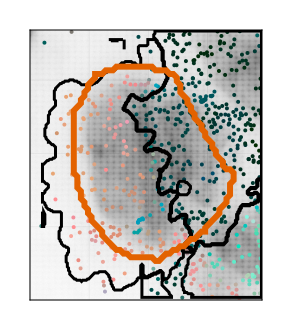

In [138]:
t_d = datasets.allen_smfish
xls, yls = (15125, 15320), (11890, 12110)

c_polys = t_d[:paper_polys][[all((p[:,2] .< yls[2]) .& (p[:,2] .> yls[1]) .& (p[:,1] .< xls[2]) .& (p[:,1] .> xls[1])) for p in t_d[:paper_polys]]];
plt = BA.plot_comparison_for_cell(t_d[:df], xls, yls, nothing, t_d[:dapi_arr]; paper_polys=c_polys, paper_poly_color="#e36200", paper_line_mult=2.0, plot_raw_dapi=false, ticks=false,
    cell1_col=:cell_paper, cell2_col=:cell, markersize=4.0, bandwidth=3.0, grid_step=1.0, polygon_line_width=3.0, alpha=0.5, dapi_alpha=0.75, polygon_alpha=0.75, size_mult=1.5,
    ylabel="Allen smFISH", labelfontsize=14)

# Plots.savefig(plt, "$PLOT_DIR/examples/allen_smfish.png")
plt

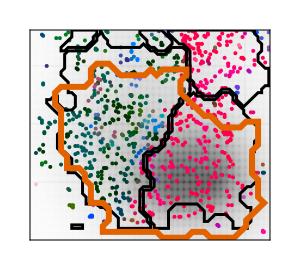

In [139]:
t_d = datasets.merfish
xls, yls = (11620, 11820), (10265, 10445)
c_polys = t_d[:paper_polys][[all((p[:,2] .< yls[2]) .& (p[:,2] .> yls[1]) .& (p[:,1] .< xls[2]) .& (p[:,1] .> xls[1])) for p in t_d[:paper_polys]]];
plt = BA.plot_comparison_for_cell(t_d[:df], xls, yls, nothing, t_d[:dapi_arr]; paper_polys=c_polys, paper_poly_color="#e36200", paper_line_mult=2.0, plot_raw_dapi=false, ticks=false,
    cell1_col=:cell_paper, cell2_col=:cell, markersize=4.0, bandwidth=5.0, grid_step=3.0, polygon_line_width=3.0, alpha=0.5, dapi_alpha=0.75, polygon_alpha=0.75, size_mult=1.5,
    ylabel="MERFISH", labelfontsize=14)

# Plots.savefig(plt, "$PLOT_DIR/examples/merfish.png")
plt

In [ ]:
# t_cd = datasets.osmfish[:part_cors][2]
# for ci in t_cd[2][sortperm(t_cd[1])][1:10]
#     display(B.plot_comparison_for_cell(datasets.osmfish[:df], ci, nothing, datasets.osmfish[:dapi_arr]; paper_polys=datasets.osmfish[:paper_polys], cell1_col=:cell_paper, cell2_col=:cell, 
#             ms=4.0, bandwidth=5.0, ticks=true))
# end

In [ ]:
# t_cd = datasets.allen_smfish[:part_cors][2]
# for ci in t_cd[2][sortperm(t_cd[1])][1:5]
#     display(B.plot_comparison_for_cell(datasets.allen_smfish[:df], ci, nothing, datasets.allen_smfish[:dapi_arr]; paper_polys=datasets.allen_smfish[:paper_polys], cell1_col=:cell_paper, cell2_col=:cell, 
#             ms=4.0, bandwidth=5.0, ticks=true))
# end

In [ ]:
# t_d = datasets.merfish
# t_cd = t_d[:part_cors][2]
# for ci in t_cd[2][sortperm(t_cd[1])][1:5]
#     display(B.plot_comparison_for_cell(t_d[:df], ci, nothing, t_d[:dapi_arr]; paper_polys=t_d[:paper_polys], cell1_col=:cell_paper, cell2_col=:cell, 
#             ms=4.0, bandwidth=5.0, ticks=true))
# end

In [ ]:
# t_d = datasets.starmap1020
# t_cd = t_d[:part_cors][2]
# for ci in t_cd[2][sortperm(t_cd[1])][1:5]
#     display(B.plot_comparison_for_cell(t_d[:df], ci, nothing, nothing; paper_polys=t_d[:paper_polys], cell1_col=:cell_paper, cell2_col=:cell, 
#             ms=4.0, bandwidth=5.0, ticks=true))
# end

### Segmentation Prior

#### Examples 1

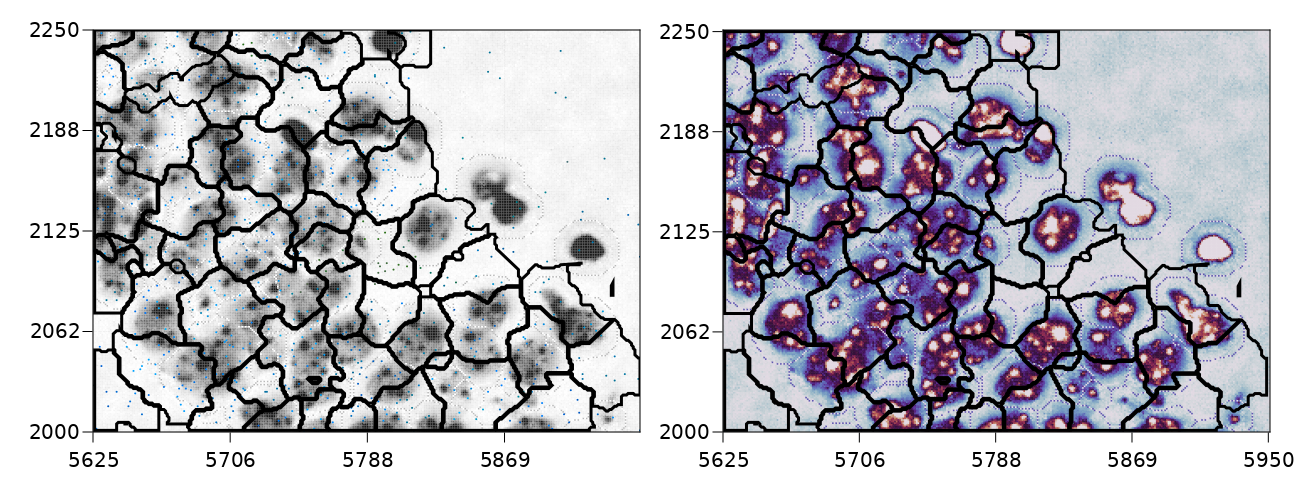

In [145]:
t_d = datasets.iss
BA.plot_comparison_for_cell(t_d[:df], (5625, 5950), (2000, 2250), nothing, t_d[:dapi_arr]; ms=4.0, alpha=0.75,
    bandwidth=3.0, grid_step=1.0, ticks=true, size_mult=2.0, polygon_line_width=3.0, polygon_alpha=0.5)

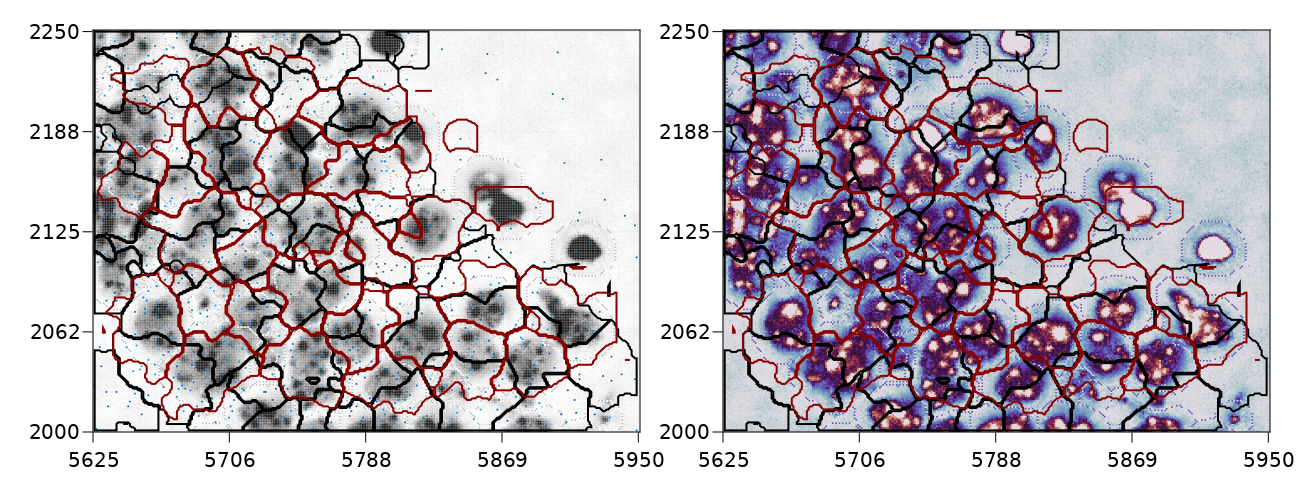

In [148]:
t_d = datasets.iss
xls, yls = (5625, 5950), (2000, 2250)
c_polys = t_d[:paper_polys][[all((p[:,2] .< yls[2]) .& (p[:,2] .> yls[1]) .& (p[:,1] .< xls[2]) .& (p[:,1] .> xls[1])) for p in t_d[:paper_polys]]];
BA.plot_comparison_for_cell(t_d[:df], xls, yls, nothing, t_d[:dapi_arr]; paper_polys=c_polys, ms=4.0, alpha=0.75,
    bandwidth=3.0, grid_step=1.0, ticks=true, size_mult=2.0, polygon_line_width=2.0, polygon_alpha=0.5)

#### Examples 2

In [ ]:
t_d = datasets.merfish
# @time t_d[:prior_polys] = B.boundary_polygons(t_d[:df], t_d[:df].cell_prior, grid_step=5.0, bandwidth=5.0)
@time t_d[:polys] = B.boundary_polygons(t_d[:df], t_d[:df].cell, grid_step=5.0, bandwidth=5.0);

In [ ]:
t_cd = t_d[:part_cors_prior][2];
for ci in t_cd[2][sortperm(t_cd[1])[t_cd[3] .> 0.1]][1:5]
    display(B.plot_comparison_for_cell(t_d[:df], ci, nothing, nothing; paper_polys=t_d[:polys], cell1_col=:cell_prior, cell2_col=:cell, 
            ms=4.0, bandwidth=5.0, ticks=true, size_mult=1.5))
end

In [ ]:
t_cd = t_d[:part_cors_prior][1];
for ci in t_cd[2][sortperm(t_cd[1])[t_cd[3] .> 0.1]][1:5]
    display(B.plot_comparison_for_cell(t_d[:df], ci, nothing, nothing; paper_polys=t_d[:prior_polys], cell1_col=:cell, cell2_col=:cell_prior, 
            ms=4.0, bandwidth=5.0, ticks=true, size_mult=1.5))
end

In [ ]:
for ci in t_cd[2][sortperm(t_cd[1])[t_cd[3] .> 0.1]][1:5]
    display(B.plot_comparison_for_cell(t_d[:df], ci, nothing, nothing; paper_polys=t_d[:prior_polys], cell1_col=:cell_prior, cell2_col=:cell, 
            ms=4.0, bandwidth=5.0, ticks=true))
end

### Supp. plots

#### Cell stats

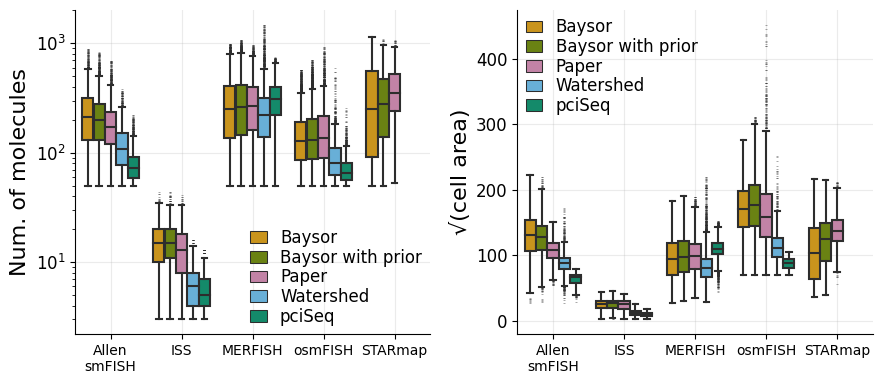

In [301]:
fig, (ax1, ax2) = Plt.subplots(1, 2, figsize=(9, 4))
for (col, lab, ax) in [(:n_transcripts, "Num. of molecules", ax1), (:sqr_area, "√(cell area)", ax2)]
    p_df = vcat(vcat([[@where(DataFrame(:Val => d[:qc_per_cell_dfs][n][!,col], :Dataset => d[:name], :Segmentation => alias_per_col[n]), :Val .< quantile(:Val, 0.995)) 
            for d in datasets if ((n in keys(d[:qc_per_cell_dfs])) && (size(d[:qc_per_cell_dfs][n], 1) > 0))] for n in cell_col_names]...)...);
    p_df.Dataset[p_df.Dataset .== "Allen smFISH"] .= "Allen\nsmFISH"

    Sns.boxplot(x=p_df.Dataset, y=p_df.Val, hue=p_df.Segmentation, hue_order=sort(unique(p_df.Segmentation)), palette=color_per_label, fliersize=0.1, ax=ax)

    ax.set_ylabel(lab)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.grid(true, axis="both")
    ax.legend(labelspacing=0.1, handlelength=1)
end

ax1.set_yscale("log")
Plt.tight_layout()
Plt.savefig(cplotsdir("cell_stats.pdf"));

#### Similarity vs Prior Confidence 

In [148]:
dir_aliases = Dict(
  "baysor_prior_05"  => "0.5",
  "baysor_prior_025" => "0.25",
  "baysor_prior_09"  => "0.9",
  "baysor_prior_075" => "0.75",
  "baysor_prior_1"   => "1.0",
  "baysor_prior_0"   => "0.0"
);

dfs = [B.load_df(datadir("exp_pro/iss_hippo/$(sd)/segmentation.csv"))[1] for sd in keys(dir_aliases)];

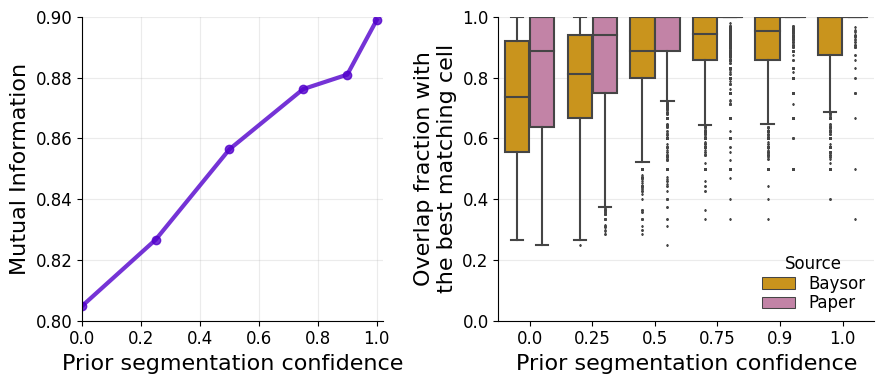

In [292]:
p_df1 = @orderby(vcat([DataFrame(:Val => Clustering.mutualinfo(d.cell, d.parent_id), :Type => n) for (n,d) in zip(values(dir_aliases), dfs)]...), :Type);

t_matches = [BA.match_assignments(d.cell, d.parent_id) for d in dfs];
min_size = 1
p_df2 = vcat([vcat([DataFrame(:Frac => tm.max_overlaps[i][vec(sum(tm.contingency, dims=(3-i)))[2:end] .>= min_size], :Confidence => n, :Type => l) for (n,tm) in zip(values(dir_aliases), t_matches)]...) 
        for (i,l) in enumerate(["Baysor", "Paper"])]...);
p_df2 = @orderby(p_df2, :Confidence);

fig, (ax1, ax2) = Plt.subplots(1, 2, figsize=(9, 4), gridspec_kw=Dict("width_ratios" => [4, 5]))
ax1.plot(parse.(Float16, p_df.Type), p_df.Val, "o-", lw=3, color="#5200cc", alpha=0.8)
ax1.set_ylabel("Mutual Information"); ax1.set_xlabel("Prior segmentation confidence");
ax1.set_xlim(0, 1.02); ax1.set_ylim(0.8, 0.9);

Sns.boxplot(x=p_df2.Confidence, y=p_df2.Frac, hue=p_df2.Type, palette=color_per_label, fliersize=1, ax=ax2)
ax2.set_ylim(0, 1);
ax2.legend(title="Source", labelspacing=0.1, loc="lower right")
ax2.set_xlabel("Prior segmentation confidence"); ax2.set_ylabel("Overlap fraction with\nthe best matching cell");
Plt.tight_layout();

Plt.savefig(cplotsdir("impact_of_prior_confidence.pdf"));